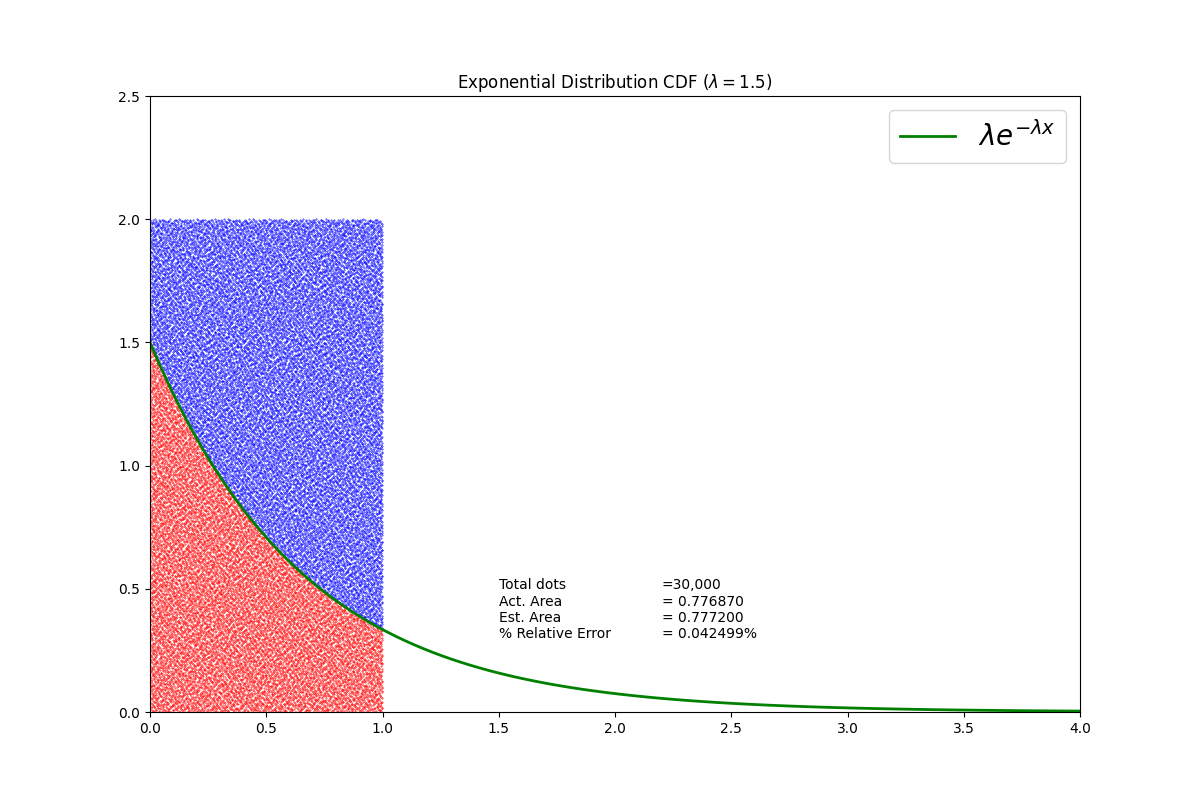

In [6]:
"""mc_exp_dist.ipynb"""
# Cell 1
# Used Dave's code

from __future__ import annotations

import typing

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import MarkerStyle
from matplotlib.patches import Rectangle
from numba import float64, vectorize #type: ignore

if typing.TYPE_CHECKING:
    from matplotlib.axes import Axes
    from numpy.typing import NDArray

%matplotlib widget

# Setting the rate parameter and sample area
rate_param: float = 1.5
sample_area = Rectangle((0, 0), 1, 2)

# Probability Density Function (PDF) of the exponential distribution
def pdf(x: NDArray[np.float_]) -> NDArray[np.float_]:
    """
    Calculates the PDF of the exponential distribution 

    Args:
        x: Array of values at which to evaluate the PDF

    Returns:
        Array of PDF values corresponding to the input values
    """
    return rate_param * np.exp(-rate_param * x)

# Cumulative Distribution Function (CDF) of the exponential distribution
def cdf(x: float) -> float:
    """
    Calculates the CDF of the exponential distribution

    Args:
        x: Value at which to evaluate the CDF

    Returns:
        CDF value corresponding to the input value
    """
    return 1 - np.exp(-rate_param * x)

# Vectorized Halton sequence generation
@vectorize([float64(float64, float64)], nopython=True) # type: ignore

def halton(n: float, p: int) -> float:
    """
    Generates the Halton sequence using the specified base.

    Args:
        n: Number of points in the sequence.
        p: Base of the sequence.

    Returns:
        Halton sequence as an array of values.
    """
    h = 0
    f = 1
    while n > 0:
        f: float = f / p
        h += (n % p) * f
        n = int(n / p)
    return h
    
# Plotting the exponential distribution CDF
def plot_exp_cdf(ax: Axes) -> None:
    """
    Plots the CDF of the exponential distribution.

    Args:
        ax: Matplotlib axes object on which to plot.
    """
    iterations: int = 30_000

    primes: list[int] = [2, 3]

    # Generating Halton sequence for x and y coordinates
    x: NDArray[np.float_] = (
        sample_area.get_x()
        + halton(np.arange(iterations), primes[0]) * sample_area.get_width() # type: ignore
    )

    y: NDArray[np.float_] = (
        sample_area.get_y()
        + halton(np.arange(iterations), primes[1]) * sample_area.get_height() # type: ignore
    )

    # Caculating the difference between PDF and y-coordinate
    d: NDArray[np.float_] = pdf(x) - y

    # Seperating points inside and outside the PDF curve
    x_in: NDArray[np.float_] = x[d >= 0.0]
    y_in: NDArray[np.float_] = y[d >= 0.0]
    x_out: NDArray[np.float_] = x[d < 0.0]
    y_out: NDArray[np.float_] = y[d < 0.0]

    pixel_size: float = (72 / ax.figure.dpi) ** 2 # type: ignore

    # Plotting points inside and outside the PDF curve
    ax.scatter(x_in, y_in, color="red", marker=MarkerStyle("."), s=pixel_size)
    ax.scatter(x_out, y_out, color="blue", marker=MarkerStyle("."), s=pixel_size)

    # Plotting the actual PDF curve
    act_x: NDArray[np.float_] = np.linspace(0, 4, 100)
    act_y: NDArray[np.float_] = pdf(act_x)
    ax.plot(act_x, act_y, color="green", linewidth=2, label=r"$\lambda e^{-\lambda x}$")
    ax.legend(loc="upper right", fontsize="20")

    # Calculating the estimated and actual areas under the PDF curve
    est_area: float =(
        np.count_nonzero(d >= 0.0)
        / iterations
        * (sample_area.get_width() * sample_area.get_height())
    )

    act_area: float = cdf(sample_area.get_x() + sample_area.get_width()) - cdf(
        sample_area.get_x()
    )
    err: float = (est_area - act_area) / act_area

    # Setting plot title, limits, and adding text annotations
    ax.set_title(rf"Exponential Distribution CDF $(\lambda={rate_param})$")
    ax.set_xlim(0, 4.0)
    ax.set_ylim(0, 2.5)

    ax.text(1.5, 0.3, "Total dots\nAct. Area\nEst. Area\n% Relative Error", ha="left")
    ax.text(
        2.2,
        0.3,
        f"={iterations:,}\n= {act_area:.6f}\n= {est_area:.6f}\n= {err:.6%}",
        ha="left",
    )

# Main function tho generate the plot
def main() -> None:
    plt.close("all")
    plt.figure(" ", figsize=(12, 8))
    # Plotting the exponential distribution CDF
    plot_exp_cdf(plt.axes())
    plt.show

main()